# Parametrische Identifikation mit OBF im Vergleich zu ARX Modellen
# Beispiel: System erster Ordnung

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sp
from random import gauss
from random import seed
from pandas import Series
#from sippy import *
#from sippy import functionset as fset
import control as ctl
import control.matlab as cnt
#from pysid import iv
#from pysid import arx
%matplotlib notebook

Erzeugung eines Testsystems

In [4]:
ts = 1
num = [1.0]
den = [1.0, -0.95]
sys_test = ctl.tf(num, den, ts)
sys_test

TransferFunction(array([1.]), array([ 1.  , -0.95]), 1)

Erzeugung eines Testsignals

Als exogenes Eingangssignal wird ein pseudo-zufälliges binäres Signal verwendet 

Als Störsignal gaussverteiltes weisses Rauschen

In [5]:
# Länge der Zeitreihe
npts = 1000
Time = np.linspace(0,999,1000)
# exogenes Signal
switch_probability = 0.08  # [0..1]
input_sequence = fset.PRBS_seq(npts, switch_probability)
# Störung
v = [gauss(0.0, 2) for i in range(1000)]

plt.figure()
plt.plot(Time, input_sequence)
plt.xlabel('Time')
plt.ylabel('u(k)')

NameError: name 'fset' is not defined

In [4]:
plt.figure()
plt.plot(Time, v)
plt.xlabel('Time')
plt.ylabel('v(k)')

<IPython.core.display.Javascript object>

Text(0, 0.5, 'v(k)')

Berechnung des Ausgangssignals durch Simulation

In [5]:
output_sequence, Time, X =  cnt.lsim(sys_test, input_sequence, Time)

In [6]:
plt.figure()
plt.plot(Time, input_sequence, label='input')
plt.plot(Time, output_sequence, label='output')
plt.xlabel('Time []')
legend = plt.legend()

<IPython.core.display.Javascript object>

Nichtparametrische Schätzung des Frequenzgangs

In [7]:
f, R_yx = sp.csd(input_sequence, np.transpose(output_sequence), nperseg=1000, noverlap=0)
f, R_xx = sp.welch(input_sequence, nperseg=1000, noverlap=0)

H_est = R_yx/R_xx

plt.figure()
plt.loglog(f,np.abs(np.transpose(H_est)))
plt.xlabel('normalized frequency')
plt.ylabel('abs(H)')

<IPython.core.display.Javascript object>

Text(0, 0.5, 'abs(H)')

ARX Schätzung des Systems

In [8]:
Identified_system = system_identification(output_sequence, input_sequence,'ARX',ARX_orders=[1,1,0])
mag, phase, omega = ctl.bode(Identified_system.G,omega=2*np.pi*f,Plot=False)
Identified_system.G

C:\Users\dmayer\AppData\Local\Continuum\anaconda3\lib\site-packages\sippy-0.1.0-py3.7.egg\sippy\arxMIMO.py:79: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.



    1
--------
z - 0.95

dt = 1.0

Vergleich der Ergebnisse - parametrische und nichtparametrische Schätzung

In [9]:
plt.figure()
plt.loglog(omega/(2*np.pi),mag,label='ARX Modell') #Identifikation mit der sysid Toolbox sippy

plt.loglog(f,np.abs(np.transpose(H_est)),label='Black Box') #Black Box Modell
plt.xlabel('normalized frequency')
plt.ylabel('|H|')
legend = plt.legend()

<IPython.core.display.Javascript object>

## Überlagerung eines Messrauschens

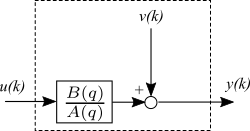

In [10]:
output_noisy = np.transpose( v  + np.transpose(output_sequence))

In [11]:
plt.figure()
plt.plot(Time, output_noisy, label = 'output noise')
plt.plot(Time, output_sequence, label = 'no noise')

plt.xlabel('Time []')
legend = plt.legend()

<IPython.core.display.Javascript object>

Identifikation eines ARX Modells

In [12]:
Identified_system_n = system_identification(output_noisy, input_sequence,'ARX',ARX_orders=[1,1,0])
mag_n, phase_n, omega_n = ctl.bode(Identified_system_n.G,omega=2*np.pi*f,Plot=False)
Identified_system_n.G

C:\Users\dmayer\AppData\Local\Continuum\anaconda3\lib\site-packages\sippy-0.1.0-py3.7.egg\sippy\arxMIMO.py:79: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.



  1.234
----------
z - 0.9035

dt = 1.0

In [13]:
plt.figure()
plt.loglog(omega/(2*np.pi),mag,label='ARX') #Identifikation mit der sysid Toolbox sippy
plt.loglog(omega_n/(2*np.pi),mag_n,label='ARX, output noise') #Identifikation mit der sysid Toolbox sippy

plt.xlabel('normalized frequency')
plt.ylabel('|H|')
legend = plt.legend()

<IPython.core.display.Javascript object>

## Schätzung durch orthonormale Basisfunktionsmodelle

## Laguerre- Funktionen

Wahl des freien Parameters

In [14]:
# Setze a gleich dem Pol der ARX-SChätzung 
a = 0.9017
#a  = 0.75

Aufbau der Elemente der Filterbank

In [15]:
# Tiefpass 
sys_1 = ctl.tf([np.sqrt(1-a**2)], [1, -a], ts)
# Allpass
sys_2 = ctl.tf([-a, 1], [1, -a], ts)

In [16]:
sys_1


  0.4324
----------
z - 0.9017

dt = 1

In [17]:
sys_2


-0.9017 z + 1
-------------
  z - 0.9017

dt = 1

Berechnung der Impulsantworten

In [18]:
Time = np.linspace(0,999,1000)
Time, h = ctl.impulse_response(sys_1, Time)

plot_length = 300
sys_n = sys_1

plt.figure()
plt.plot(Time[1:plot_length], h.T[1:plot_length], label='Laguerre- Funktion l_1')

for n in range(3):
    sys_n = ctl.series(sys_n, sys_2)
    Time, h = ctl.impulse_response(sys_n, Time)
    plt.plot(Time[1:plot_length], h.T[1:plot_length], label='Laguerre- Funktion l_'+str(n+2))
    
plt.legend()
plt.xlabel('Time')
plt.ylabel('l')

<IPython.core.display.Javascript object>

Text(0, 0.5, 'l')

Aufbau der Regressionsmatrix

In [19]:
# Modellordnung N
N = 4
# Länge der Zeitreihe
K = 300

Time = np.linspace(0, K-1, K)
phi_mat = np.zeros((K, N))

Time, h, X = ctl.forced_response(sys_1, Time, input_sequence[0:K])
phi_mat[:,0] = h
sys_n = sys_1

for n in range(N-1):
    sys_n = ctl.series(sys_n, sys_2)
    Time, h, X = ctl.forced_response(sys_n, Time, input_sequence[0:K])
    phi_mat[:,n+1] = h

Lösen des überbestimmten Gleichungssysstems

In [20]:
THETA = np.dot(np.linalg.pinv(phi_mat), output_noisy[0:K])
print(THETA)

[3.02711652 1.00828683 0.25022752 0.17534449]


Aufbau des Modells durch Linearkombination der Übertragungsfunktionen mit den Komponenten des Parametervektors

Berechnung des Ausgangssignals der Filterbank 

In [21]:
y_dach = np.dot(phi_mat,THETA)

In [22]:
plt.figure()
plt.plot(Time, output_noisy[0:K], label = 'output w/ noise')
plt.plot(Time, y_dach, label = 'Laguerre model')
plt.xlabel('Time []')
legend = plt.legend()

<IPython.core.display.Javascript object>

## Validierung mit einem Abschnitt der Zeitreihe, der nicht für die Identifikation genutzt wurde

In [23]:
# Länge der Zeitreihe
K = 500

# Offset in der Zeitreihe: Validierung mit einem anderen Abschnitt des Signals
Offset = 400

Time = np.linspace(0, K-1, K)
phi_mat = np.zeros((K, N))

Time, h, X = ctl.forced_response(sys_1, Time, input_sequence[Offset:Offset+K])
phi_mat[:,0] = h
sys_n = sys_1

for n in range(N-1):
    sys_n = ctl.series(sys_n, sys_2)
    Time, h, X = ctl.forced_response(sys_n, Time, input_sequence[Offset:Offset+K])
    phi_mat[:,n+1] = h

In [24]:
y_dach = np.dot(phi_mat,THETA)

In [25]:
plt.figure()
plt.plot(Time+Offset, output_noisy[Offset:Offset+K], label = 'output w/ noise' )
plt.plot(Time+Offset, y_dach, label = 'Laguerre model')
plt.xlabel('Time []')
legend = plt.legend()

<IPython.core.display.Javascript object>

Zum Vergleich: Ausgangssignal des ARX-Modells

In [26]:
Time, y_ARX, X = ctl.forced_response(Identified_system_n.G, Time, input_sequence[Offset:Offset+K])

<IPython.core.display.Javascript object>


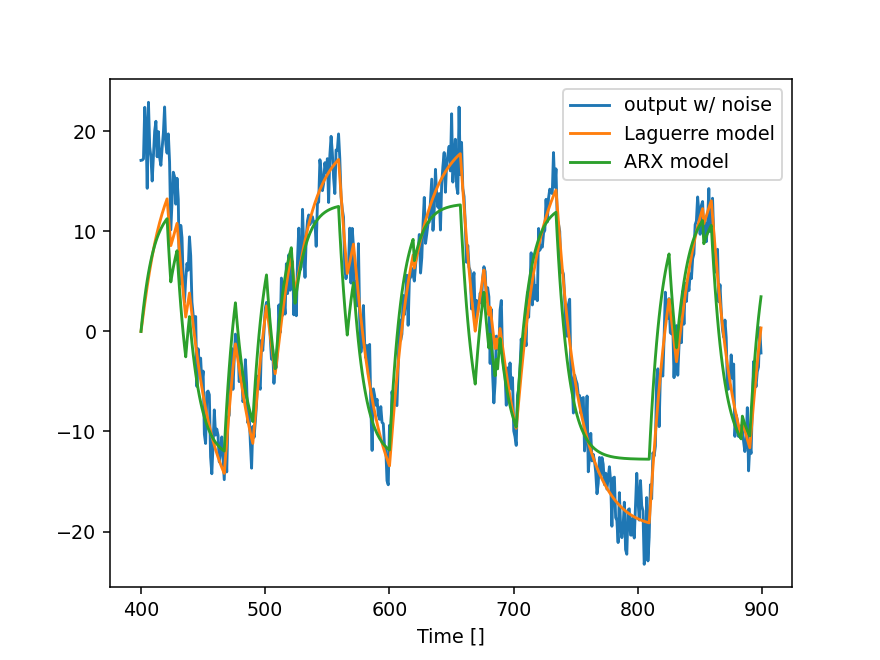

In [29]:
plt.figure()
plt.plot(Time+Offset, output_noisy[Offset:Offset+K], label = 'output w/ noise' )
plt.plot(Time+Offset, y_dach, label = 'Laguerre model')
plt.plot(Time+Offset, y_ARX.T, label = 'ARX model')
plt.xlabel('Time []')
legend = plt.legend()


In [30]:
sys_M1 = sys_1
sys_M1 = ctl.series(sys_M1, THETA[0])

sys_modell = sys_M1

sys_n = sys_1

for n in range(N-1):
    sys_n = ctl.series(sys_n,sys_2)
    sys_Mn = sys_n
    sys_Mn = ctl.series(sys_Mn, THETA[n+1])
    sys_modell = ctl.parallel(sys_modell, sys_Mn)
    
sys_modell


    0.9481 z^9 - 7.615 z^8 + 27.17 z^7 - 56.55 z^6 + 75.64 z^5 - 67.43 z^4 + 40.06 z^3 - 15.3 z^2 + 3.406 z - 0.3369
-----------------------------------------------------------------------------------------------------------------------
z^10 - 9.017 z^9 + 36.59 z^8 - 87.98 z^7 + 138.8 z^6 - 150.2 z^5 + 112.9 z^4 - 58.16 z^3 + 19.67 z^2 - 3.941 z + 0.3553

dt = 1

In [31]:
mag_l, phase_l, omega_l = ctl.bode(sys_modell,omega=2*np.pi*f,Plot=False)

<IPython.core.display.Javascript object>


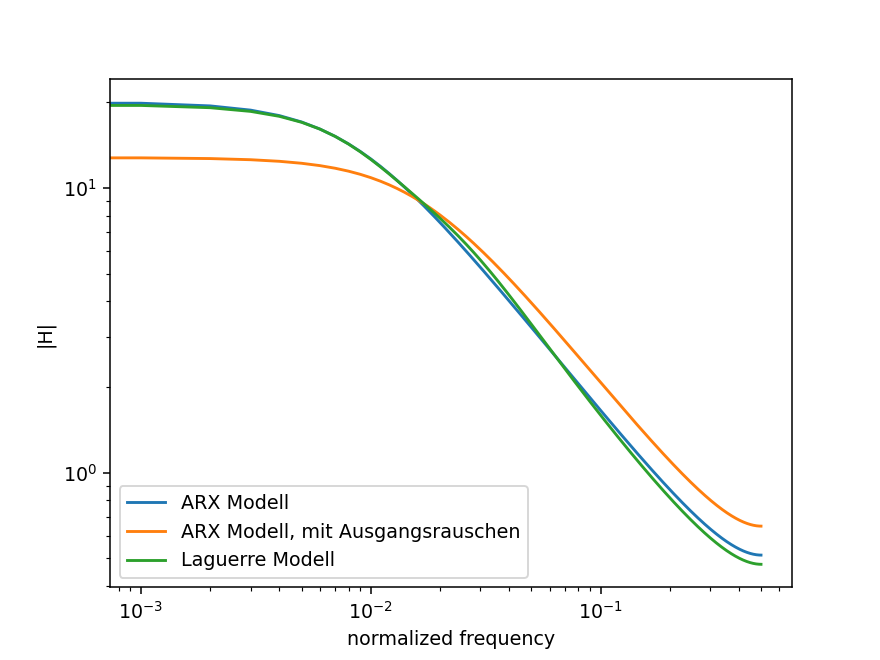

In [32]:
plt.figure()
plt.loglog(omega/(2*np.pi),mag,label='ARX Modell') #Identifikation mit der sysid Toolbox sippy
plt.loglog(omega_n/(2*np.pi),mag_n,label='ARX Modell, mit Ausgangsrauschen') #Identifikation mit der sysid Toolbox sippy
plt.loglog(omega_l/(2*np.pi),mag_l,label='Laguerre Modell') 

plt.xlabel('normalized frequency')
plt.ylabel('|H|')
legend = plt.legend()